In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import uniform

In [84]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [85]:
# Drop unnecessary columns
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

# Fill missing values in 'Age' with the median age
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

# Fill missing values in 'Fare' with the median fare
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Extract the cabin code
train_df['Cabin_Code'] = train_df['Cabin'].str.extract(r'([A-Za-z])', expand=False)

cabin_groups = {
    'T': 'Upper',
    'A': 'Upper',
    'B': 'Upper',
    'C': 'Middle',
    'D': 'Middle',
    'E': 'Middle',
    'F': 'Lower',
    'G': 'Lower'
}
train_df['Cabin_Category'] = train_df['Cabin_Code'].map(cabin_groups)


train_df = train_df.drop(['Cabin_Code', 'Cabin'], axis=1)

# Convert categorical variables into dummy/indicator variables
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [87]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_Category_Lower,Cabin_Category_Middle,Cabin_Category_Upper
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,1,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,1,0
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0


In [88]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
xgb_model = xgb.XGBClassifier()
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 10.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 10.0]
}

Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.7}


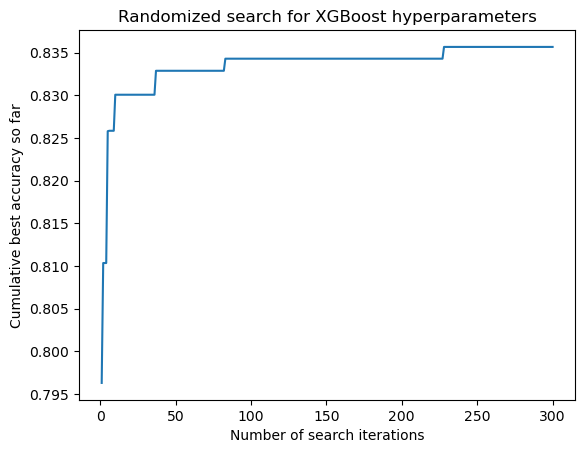

In [90]:
rs = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=300, n_jobs=-1, cv=5, random_state=42, return_train_score=True)
rs.fit(X_train, y_train)
print('Best Parameters:', rs.best_params_)

best_acc_so_far = 0.0
accuracy_history = []


for score in rs.cv_results_['mean_test_score']:
    # Fit the model and update the best accuracy so far
    if score > best_acc_so_far:
        best_acc_so_far = score
    accuracy_history.append(best_acc_so_far)

plt.plot(np.arange(1, 301), accuracy_history)
plt.xlabel('Number of search iterations')
plt.ylabel('Cumulative best accuracy so far')
plt.title('Randomized search for XGBoost hyperparameters')
plt.show()

In [94]:
**rs.best_params_

SyntaxError: invalid syntax (1420463644.py, line 1)

In [95]:
rs.best_params_

{'subsample': 1.0,
 'reg_lambda': 1.0,
 'reg_alpha': 1.0,
 'min_child_weight': 5,
 'max_depth': 9,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'colsample_bytree': 0.7}

In [96]:
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_Category_Lower,Cabin_Category_Middle,Cabin_Category_Upper
331,1,45.5,0,0,28.5000,0,1,0,0,1,0,1,0
733,2,23.0,0,0,13.0000,0,1,0,0,1,0,0,0
382,3,32.0,0,0,7.9250,0,1,0,0,1,0,0,0
704,3,26.0,1,0,7.8542,0,1,0,0,1,0,0,0
813,3,6.0,4,2,31.2750,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,3,21.0,0,0,7.6500,1,0,0,0,1,0,0,0
270,1,28.0,0,0,31.0000,0,1,0,0,1,0,0,0
860,3,41.0,2,0,14.1083,0,1,0,0,1,0,0,0
435,1,14.0,1,2,120.0000,1,0,0,0,1,0,0,1


In [91]:
xgb_model = xgb.XGBClassifier(**rs.best_params_)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [92]:
y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.8268156424581006


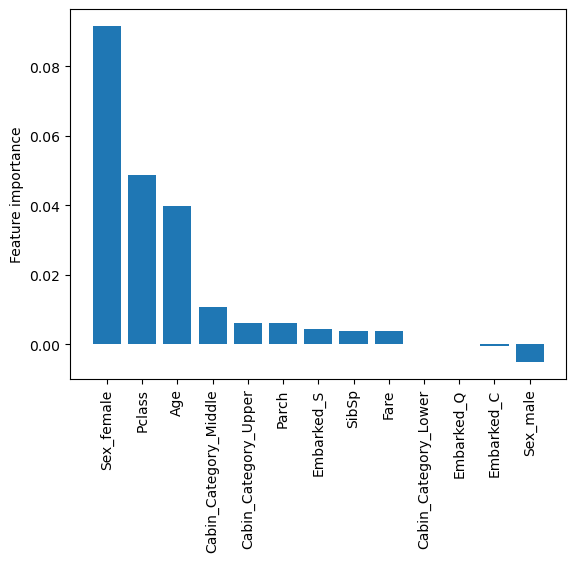

In [93]:
from sklearn.inspection import permutation_importance

# fit the xgboost model on training data
# model.fit(X_train, y_train)

# calculate permutation importance on validation data
results = permutation_importance(xgb_model, X_val, y_val, scoring='accuracy', n_repeats=10, random_state=42)

# extract feature importances from results
importances = results.importances_mean

sorted_idx = importances.argsort()[::-1]  # get the index order for sorting the features by importance
plt.bar(range(X_val.shape[1]), importances[sorted_idx])
plt.xticks(range(X_val.shape[1]), X_val.columns[sorted_idx], rotation=90)
plt.ylabel('Feature importance')
plt.show()